In [2]:
### This script will plot some graphics showing the relative locations of the ZDR and KDP maxes in the storm.
import matplotlib.pyplot as plt
import pyart
import numpy as np
import numpy.ma as ma
from metpy.units import atleast_1d, check_units, concatenate, units
from matplotlib.patches import PathPatch
from matplotlib.path import Path
from siphon.radarserver import RadarServer
rs = RadarServer('http://thredds-aws.unidata.ucar.edu/thredds/radarServer/nexrad/level2/S3/')
#rs = RadarServer('http://thredds.ucar.edu/thredds/radarServer/nexrad/level2/IDD/')
from datetime import datetime, timedelta
from siphon.cdmr import Dataset
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from metpy.units import atleast_1d, check_units, concatenate, units
from shapely.geometry import polygon as sp
import pyproj 
import shapely.ops as ops
from shapely.ops import transform
from shapely.geometry.polygon import Polygon
from functools import partial
from shapely import geometry
import netCDF4
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage import data, img_as_float
from pyproj import Geod


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



C:\Users\mwilson41\AppData\Local\Continuum\Anaconda3\envs\radar\lib\site-packages\urllib3\contrib\pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


(-104.32972222222222, 42.625, <cartopy.crs.PlateCarree object at 0x0000026BC1D448E0>)
hi
hi
hi
hi
hi
hi
hi
hi
hi
(11,)
hi
hi
hi
hi
(11,)
hi
hi
hi
hi
(11,)
hi
hi
(11,)
hi
hi
hi
hi
hi
hi
(11,)
hi
hi
hi
hi
hi
hi
hi
hi
1
-103.47012891525654
1
-102.8495759836061
1
-102.99682485654533
1
-103.37242658445086
1
-103.5515776566568
1
-103.34513701236475


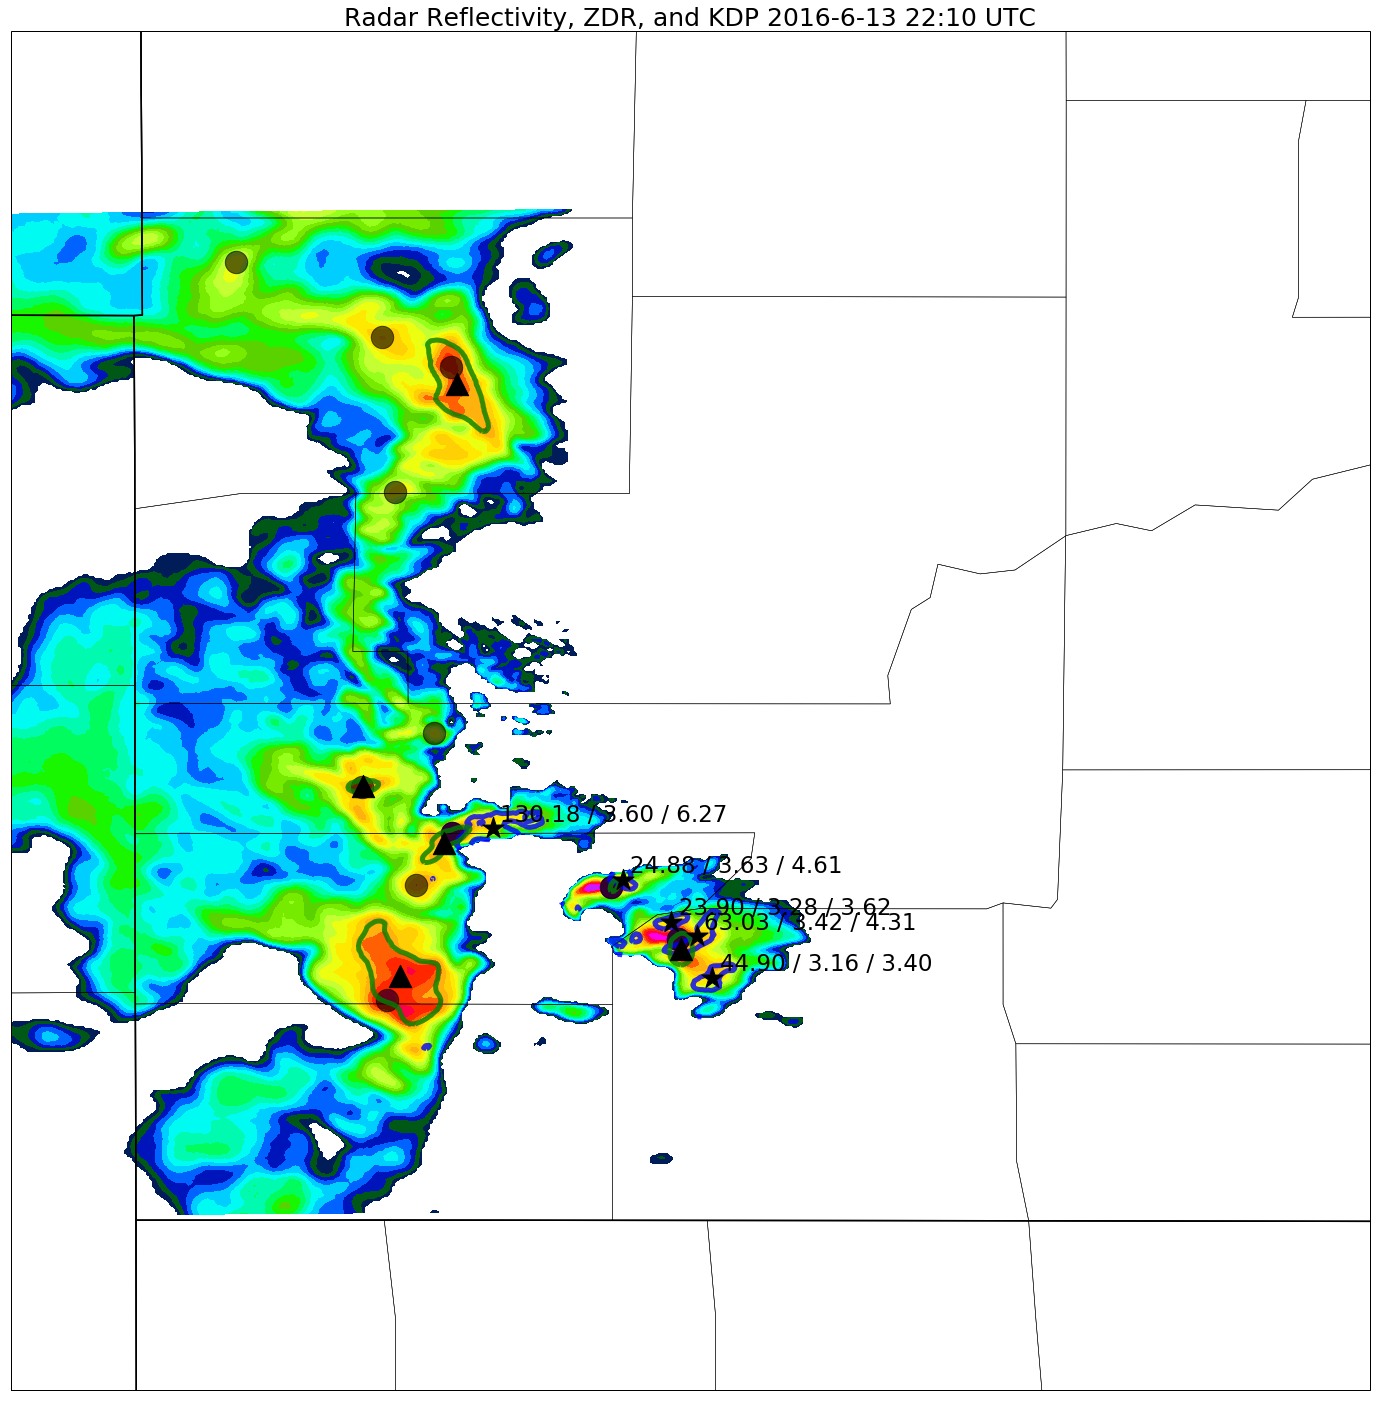

In [29]:
query = rs.query()
#Here, set the initial time of the archived radar loop you want.
dt = datetime(2016, 6, 13, 22, 10) # Our specified time
station = 'KUDX'
query.stations(station).time_range(dt, dt + timedelta(hours=.1))
cat = rs.get_catalog(query)
cat.datasets
f = 27
n = 1
for item in sorted(cat.datasets.items()):
    # After looping over the list of sorted datasets, pull the actual Dataset object out
    # of our list of items and access over CDMRemote
    try:
        ds = item[1]
        radar = pyart.io.nexrad_cdm.read_nexrad_cdm(ds.access_urls['OPENDAP'])
        time_start = netCDF4.num2date(radar.time['data'][0], radar.time['units'])
        #Now let's calculate and plot specific differential phase.
        radar = radar.extract_sweeps([0])
        kdp_dict = pyart.retrieve.kdp_proc.kdp_maesaka(radar)
        radar.add_field('KDP', kdp_dict[0])

        # mask out last 10 gates of each ray, this removes the "ring" around the radar.
        radar.fields['differential_reflectivity']['data'][:, -10:] = np.ma.masked

        # exclude masked gates from the gridding
        gatefilter = pyart.filters.GateFilter(radar)
        gatefilter.exclude_masked('differential_reflectivity')

        #Now let's grid the data
        grid = pyart.map.grid_from_radars(
            (radar,), gatefilters=(gatefilter, ),
            grid_shape=(1, 500, 500),
            grid_limits=((200, 200), (-123000.0, 123000.0), (-123000.0, 123000.0)),
            fields=['differential_reflectivity','reflectivity','KDP'])

        #Get the data from the grid
        ZDR = grid.fields['differential_reflectivity']['data'][0]
        REF = grid.fields['reflectivity']['data'][0]
        KDP = grid.fields['KDP']['data'][0]

    #Mask everything below 20dbz
    #import numpy.ma as ma
        ZDRmasked = ma.masked_where(REF < 20, ZDR)
        REFmasked = ma.masked_where(REF < 20, REF)
        KDPmasked = ma.masked_where(REF < 20, KDP)

        rlons = grid.point_longitude['data']
        rlats = grid.point_latitude['data']
        cenlat = radar.latitude['data'][0]
        cenlon = radar.longitude['data'][0]
        #Let's set up the map projection!
        # Set up our projection
        crs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)

        # Set up our array of latitude and longitude values and transform to 
        # the desired projection.

        tlatlons = crs.transform_points(ccrs.LambertConformal(central_longitude=265, central_latitude=25, standard_parallels=(25.,25.)),rlons[0,:,:],rlats[0,:,:])
        tlons = tlatlons[:,:,0]
        tlats = tlatlons[:,:,1]

        # Limit the extent of the map area, must convert to proper coords.
        LL = (cenlon-1.5,cenlat-1.5,ccrs.PlateCarree())
        UR = (cenlon+1.5,cenlat+1.5,ccrs.PlateCarree())
        print(LL)

        # Get data to plot state and province boundaries
        states_provinces = cfeature.NaturalEarthFeature(
                category='cultural',
                name='admin_1_states_provinces_lakes',
                scale='50m',
                facecolor='none')
        fname = 'cb_2016_us_county_20m/cb_2016_us_county_20m.shp'
        fname2 = 'cb_2016_us_state_20m/cb_2016_us_state_20m.shp'
        counties = ShapelyFeature(Reader(fname).geometries(),ccrs.PlateCarree(), facecolor = 'none', edgecolor = 'black')
        states = ShapelyFeature(Reader(fname2).geometries(),ccrs.PlateCarree(), facecolor = 'none', edgecolor = 'black')
        fig=plt.figure(n,figsize=(30.,25.))
        ax = plt.subplot(111,projection=ccrs.PlateCarree())
        ax.coastlines('50m',edgecolor='black',linewidth=0.75)
        #ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)
        ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
        ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
        ax.set_extent([LL[0],UR[0],LL[1],UR[1]])
        REFlevels = np.arange(20,73,2)
        ax.contourf(rlons[0,:,:],rlats[0,:,:],REFmasked,REFlevels,cmap = plt.cm.gist_ncar)
        
        #Plot local maxes in reflectivity
        # image_max is the dilation of im with a 20*20 structuring element
        # It is used within peak_local_max function
        image_max = ndi.maximum_filter(REFmasked, size=15, mode='constant')

        # Comparison between image_max and im to find the coordinates of local maxima
        coordinates = peak_local_max(REFmasked, min_distance=15)
        ref_maxes = REFmasked[coordinates[:,0], coordinates[:,1]]
        max_lons = rlons[0,coordinates[:,0], coordinates[:,1]]
        max_lats = rlats[0,coordinates[:,0], coordinates[:,1]]
        max_lons_c = max_lons[ref_maxes > 45]
        max_lats_c = max_lats[ref_maxes > 45]
        
        ZDRlevels = np.arange(3, np.max(ZDRmasked)+((np.max(ZDRmasked))-3)/2, (np.max(ZDRmasked))-3)
        zdrlev = [3.0]
        kdplev = [1.5]
        #ZDRlevels = np.arange(3,5.5,.5)
        #ZDRlevels1 = np.arange(5,10,.5)
        KDPlevels = np.arange(.75, np.max(KDPmasked)+((np.max(KDPmasked))-1.5)/2, (np.max(KDPmasked))-1.5)
        #KDPlevels = np.arange(.75,1.75,.25)
        #KDPlevels1 = np.arange(1.5,10,.25)
        zdrc = ax.contour(rlons[0,:,:],rlats[0,:,:],ZDRmasked,zdrlev,linewidths = 5, colors='blue', alpha = .8)
        #zrdc = ax.contourf(rlons[0,:,:],rlats[0,:,:],ZDRmasked,ZDRlevels,linewide = .01, colors='pink', alpha = .8)
        #ax.contourf(rlons[0,:,:],rlats[0,:,:],ZDRmasked,ZDRlevels1,linewide = .01, colors='crimson', alpha = .8)

        #kdpc = ax.contourf(rlons[0,:,:],rlats[0,:,:],KDPmasked,KDPlevels,linewide = .01, colors ='green', alpha = .5)
        kdpc = ax.contour(rlons[0,:,:],rlats[0,:,:],KDPmasked,kdplev,linewidths = 5, colors='green', alpha = .8)
        #ax.contourf(rlons[0,:,:],rlats[0,:,:],KDPmasked,KDPlevels1,linewide = .01, colors ='b', alpha = .5)
        plt.savefig('testfig.png')

        proj = partial(pyproj.transform, pyproj.Proj(init='epsg:4326'),
                   pyproj.Proj(init='epsg:3857'))
        zdr_areas = []
        zdr_centroid_lon = []
        zdr_centroid_lat = []
        zdr_mean = []
        zdr_max = []
        zdr_storm_lon = []
        zdr_storm_lat = []
        for col in zdrc.collections:
            # Loop through all polygons that have the same intensity level
            print('hi')
            for contour_path in col.get_paths(): 
                # Create the polygon for this intensity level
                # The first polygon in the path is the main one, the following ones are "holes"
                print('hi')
                for ncp,cp in enumerate(contour_path.to_polygons()):
                    print('hi')
                    cpa = np.asarray(cp[:])
                    x = cpa[:,0]
                    y = cpa[:,1]
                    new_shape = geometry.Polygon([(i[0], i[1]) for i in zip(x,y)])
                    if ncp == 0:
                        poly = new_shape
                        #print('hi')
                    else:
                        # Remove the holes if there are any
                        poly = poly.difference(new_shape)
                        #print('hi')

                # do something with polygon
                #print(poly.area) 
                #print(poly.centroid.x)
                s_new = transform(proj, poly)
                projected_area = (transform(proj, poly).area * units('m^2')).to('km^2')
                boundary = np.asarray(poly.boundary.xy)
                polypath = Path(boundary.transpose())
                coord_map = np.vstack((rlons[0,:,:].flatten(), rlats[0,:,:].flatten())).T # create an Mx2 array listing all the coordinates in field
                mask = polypath.contains_points(coord_map).reshape(rlons[0,:,:].shape)
                mean = np.mean(ZDRmasked[mask])
                if projected_area > 20 * units('km^2') and mean > zdrlev[0]:
                    g = Geod(ellps='sphere')
                    dist = np.zeros((np.asarray(max_lons_c).shape[0]))
                    for i in range(dist.shape[0]):
                                distance_1 = g.inv(poly.centroid.x, poly.centroid.y,
                                                       max_lons_c[i], max_lats_c[i])
                                #print(distance_1[2]/1000)
                                dist[i] = distance_1[2]/1000.
                    print(dist.shape)
                    zdr_storm_lon.append((max_lons_c[np.where(dist == np.min(dist))[0][0]]))
                    zdr_storm_lat.append((max_lats_c[np.where(dist == np.min(dist))[0][0]]))
                    zdr_areas.append((projected_area))
                    zdr_centroid_lon.append((poly.centroid.x))
                    zdr_centroid_lat.append((poly.centroid.y))
                    zdr_mean.append((mean))
                    zdr_max.append((np.max(ZDRmasked[mask])))
                #print(s_new)

        kdp_areas = []
        kdp_centroid_lon = []
        kdp_centroid_lat = []

        for col in kdpc.collections:
            # Loop through all polygons that have the same intensity level
            for contour_path in col.get_paths(): 
                # Create the polygon for this intensity level
                # The first polygon in the path is the main one, the following ones are "holes"
                for ncp,cp in enumerate(contour_path.to_polygons()):
                    print(1)
                    cpa = np.asarray(cp[:])
                    x = cpa[:,0]
                    y = cpa[:,1]
                    new_shape = geometry.Polygon([(i[0], i[1]) for i in zip(x,y)])
                    if ncp == 0:
                        poly = new_shape
                    else:
                        # Remove the holes if there are any
                        poly = poly.difference(new_shape)

                # do something with polygon
                #print(poly.area) 
                print(poly.centroid.x)
                s_new = transform(proj, poly)
                projected_area = (transform(proj, poly).area * units('m^2')).to('km^2')
                if projected_area > 20 * units('km^2'):
                    kdp_areas.append((projected_area))
                    kdp_centroid_lon.append((poly.centroid.x))
                    kdp_centroid_lat.append((poly.centroid.y))

            #print(s_new)

        if np.asarray(zdr_centroid_lon).shape[0] > 0:
            ax.scatter(zdr_centroid_lon, zdr_centroid_lat, marker = '*', s = 500, color = 'black', zorder = 10, transform=ccrs.PlateCarree())
        if np.asarray(kdp_centroid_lon).shape[0] > 0:
            ax.scatter(kdp_centroid_lon, kdp_centroid_lat, marker = '^', s = 500, color = 'black', zorder = 10, transform=ccrs.PlateCarree())
        for i in enumerate(zdr_areas):
            plt.text(zdr_centroid_lon[i[0]]+.016, zdr_centroid_lat[i[0]]+.016, "%.2f / %.2f / %.2f" %(zdr_areas[i[0]].magnitude, zdr_mean[i[0]], zdr_max[i[0]]), size = 23)
            #plt.annotate(zdr_areas[i[0]], (zdr_centroid_lon[i[0]],zdr_centroid_lat[i[0]]))
        #ax.contourf(rlons[0,:,:],rlats[0,:,:],KDPmasked,KDPlevels1,linewide = .01, colors ='b', alpha = .5)
        #plt.tight_layout()
        #plt.savefig('ZDRarcannotated.png')
        hour = time_start.hour
        if hour < 10:
            hour = '0'+str(hour)
        minute = time_start.minute
        if minute < 10:
            minute = '0'+str(minute)
        day = time_start.day
        if day < 10:
            day = '0'+str(day)
        title_plot = plt.title('Radar Reflectivity, ZDR, and KDP '+str(time_start.year)+'-'+str(time_start.month)+'-'+str(time_start.day)+
                                   ' '+str(hour)+':'+str(minute)+' UTC', size = 25)
        
        if np.asarray(zdr_storm_lon).shape[0] > 0:
            ax.scatter(zdr_storm_lon,zdr_storm_lat, marker = "o", color = 'purple', s = 500)
        ax.scatter(max_lons_c,max_lats_c, marker = "o", color = 'k', s = 500, alpha = .6)
        #ax.quiver(zdr_centroid_lon, zdr_centroid_lat, (zdr_storm_lon-zdr_centroid_lon)*10000,(zdr_storm_lat-zdr_centroid_lat)*10000)
        plt.savefig('ZDRArc_test'+station+str(time_start.year)+str(time_start.month)+str(day)+str(hour)+'0'+str(minute)+'.png')
        n = n+1
    except:
        continue

plt.show()

In [4]:
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage import data, img_as_float

In [5]:
# image_max is the dilation of im with a 20*20 structuring element
# It is used within peak_local_max function
image_max = ndi.maximum_filter(REFmasked, size=20, mode='constant')

# Comparison between image_max and im to find the coordinates of local maxima
coordinates = peak_local_max(REFmasked, min_distance=20)

In [18]:
print(coordinates)
ref_maxes = REFmasked[coordinates[:,0], coordinates[:,1]]
print(REFmasked[coordinates[:,0], coordinates[:,1]])
max_lons = rlons[0,coordinates[:,0], coordinates[:,1]]
max_lats = rlats[0,coordinates[:,0], coordinates[:,1]]
print(max_lons, ref_maxes)
print(ref_maxes[ref_maxes > 45])
print(max_lons[ref_maxes > 45])

[[461 399]
 [459 299]
 [396 235]
 [385 278]
 [358 267]
 [357 302]
 [343 151]
 [319  86]
 [309 304]
 [282 199]
 [246 189]
 [234 143]
 [229  40]
 [221  85]
 [216 230]
 [ 70 101]
 [ 24  61]]
[53.684818267822266 21.297231674194336 23.26955795288086 44.1059684753418
 40.84910583496094 49.86150360107422 58.17109298706055 61.86264419555664
 64.28874206542969 54.90545654296875 44.89411163330078 49.91499328613281
 49.24262237548828 33.038352966308594 23.70311737060547 24.623008728027344
 32.43210983276367]
[ -98.16430991  -98.70753055  -99.05487742  -98.82220982  -98.88185476
  -98.69280238  -99.5080486   -99.8577442   -98.68275386  -99.24808214
  -99.30126192  -99.54790621 -100.10031063  -99.858537    -99.08093467
  -99.76648635  -99.97691995] [53.684818267822266 21.297231674194336 23.26955795288086 44.1059684753418
 40.84910583496094 49.86150360107422 58.17109298706055 61.86264419555664
 64.28874206542969 54.90545654296875 44.89411163330078 49.91499328613281
 49.24262237548828 33.038352966308

In [28]:
#Adapted from Unidata dx dy example
from pyproj import Geod
g = Geod(ellps='sphere')
dist = np.zeros((np.asarray(zdr_centroid_lon).shape[0],np.asarray(max_lons_c).shape[0]))
for i in range(dist.shape[0]):
        for j in range(dist.shape[1]):
            distance_1 = g.inv(zdr_centroid_lon[i], zdr_centroid_lat[i],
                                   max_lons_c[j], max_lats_c[j])
            #print(distance_1[2]/1000)
            dist[i, j] = distance_1[2]/1000.
print(dist.shape)

(4, 4)


In [29]:
print(dist)

[[  82.30970154   61.69242609   49.78695503   10.45820882]
 [  82.30970154   61.69242609   49.78695503   10.45820882]
 [  36.19168674   76.95746622   93.2850298   126.85333602]
 [  62.43698965    6.23084636   14.33501052   67.71361353]]


In [42]:
#Adapted from Unidata dx dy example
from pyproj import Geod
g = Geod(ellps='sphere')
dist = np.zeros((np.asarray(max_lons_c).shape[0]))
for i in range(dist.shape[0]):
            distance_1 = g.inv(zdr_centroid_lon[3], zdr_centroid_lat[3],
                                   max_lons_c[i], max_lats_c[i])
            #print(distance_1[2]/1000)
            dist[i] = distance_1[2]/1000.
print(dist.shape)

(4,)


In [45]:
print(dist)
print(np.where(dist == np.min(dist))[0][0])

[ 62.43698965   6.23084636  14.33501052  67.71361353]
1


In [49]:
print(zdr_storm_lat)

[47.520529426448412, 47.520529426448412, 48.296970229866595, 48.10908974957372]
